In [1]:
import pandas as pd
import json
import numpy as np
import os
import pickle
import ltr.metrics as metrics


def extract_config(df, col='config'):
    for key in df[col].iloc[0]:
        df[key] = df[col].apply(lambda x: x[key])

In [13]:
0.98*np.arange(5), 0.75*np.arange(5), 0.68*np.arange(5), 0.65*np.arange(5)

(array([0.  , 0.98, 1.96, 2.94, 3.92]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 array([0.  , 0.68, 1.36, 2.04, 2.72]),
 array([0.  , 0.65, 1.3 , 1.95, 2.6 ]))

# LTR


In [2]:
def read_results(jobid=None, last_line=True, results_dir = '/ivi/ilps/personal/avardas/_data/groupbias/'):
    files_list = os.listdir(results_dir)

    dfs = []
    for file in files_list:
        if ((jobid is not None and jobid in file) or (jobid is None)) and file.endswith('.json'):
            df = pd.read_json(os.path.join(results_dir, file), lines=True)
            df['file_name'] = file
            if last_line:
                df = df.iloc[-1:,:]
            dfs.append(df)
    return pd.concat(dfs)

def print_grouped(df):
    gdf = df.groupby(['dataset', 'suffix', 'feature_id'])

    for g, df_ in gdf:
        print(g)
#         print(df_[['beta', 'test', 'test_0', 'test_1']].sort_values('beta').to_markdown())
        print(df_[['beta', 'ndcg', 'ndcg_A', 'ndcg_N', 'arr', 'arr_A', 'arr_N', 'train_ndcg_b']].sort_values('beta').to_markdown())
    
def compute_metrics(df, results_dir = '/ivi/ilps/personal/avardas/_data/groupbias/'):
    df[['ndcg', 'ndcg_A', 'ndcg_N', 'arr', 'arr_A', 'arr_N']] = -1.
    df = df.reset_index()
    for idx in df.index:
        filename = df.iloc[idx].file_name
        with open(results_dir + filename.replace('json', 'out.pkl'), 'rb') as f:
            results = pickle.load(f)
        results = type('results', (object,), results)
        M0 = metrics.LTRMetrics(np.round(results.lv/4,0)*(1 - results.g), np.diff(results.dlr), results.pred)
        M1 = metrics.LTRMetrics(np.round(results.lv/4,0)*results.g, np.diff(results.dlr), results.pred)
        M = metrics.LTRMetrics(np.round(results.lv/4,0), np.diff(results.dlr), results.pred)
        df.at[idx,'ndcg'] = M.NDCG(10)
        df.at[idx,'ndcg_A'] = M0.NDCG(10)
        df.at[idx,'ndcg_N'] = M1.NDCG(10)
        df.at[idx,'arr'] = M.ARR()
        df.at[idx,'arr_A'] = M0.ARR()
        df.at[idx,'arr_N'] = M1.ARR()
    return df


In [8]:
# df = pd.concat([read_results(jobid='529319'), read_results(jobid='529490'), read_results(jobid='530379')])
# extract_config(df)
df = df.loc[df.jobid != 53037938]
df = compute_metrics(df)
with open('affected_0.pkl', 'wb') as f:
    pickle.dump(df, f)

In [14]:
print_grouped(df)

('mslr', 'normal', 13)
|    |   beta |     ndcg |   ndcg_A |   ndcg_N |      arr |    arr_A |    arr_N |   train_ndcg_b |
|---:|-------:|---------:|---------:|---------:|---------:|---------:|---------:|---------------:|
| 22 |   0.55 | 0.280262 | 0.266146 | 0.180512 | 1.02973  | 0.774427 | 0.2553   |       0.730841 |
| 14 |   0.65 | 0.280262 | 0.266146 | 0.180512 | 1.02973  | 0.774427 | 0.2553   |       0.730841 |
|  3 |   0.75 | 0.28695  | 0.281086 | 0.169958 | 1.01114  | 0.748524 | 0.262612 |       1        |
| 20 |   0.9  | 0.292939 | 0.285221 | 0.174099 | 0.999274 | 0.743394 | 0.255879 |       1        |
| 17 |   1    | 0.320876 | 0.344486 | 0.131695 | 0.912145 | 0.589611 | 0.322534 |       1        |
('mslr', 'normal', 126)
|    |   beta |     ndcg |   ndcg_A |   ndcg_N |      arr |    arr_A |    arr_N |   train_ndcg_b |
|---:|-------:|---------:|---------:|---------:|---------:|---------:|---------:|---------------:|
| 19 |   0.55 | 0.282013 | 0.278911 | 0.154036 | 1.02048  | 0.

In [15]:
df2 = pd.concat([read_results(jobid='529915')])
extract_config(df2)

df2 = compute_metrics(df2)

with open('affected_1.pkl', 'wb') as f:
    pickle.dump(df2, f)
    
print_grouped(df2)

('mslr', 'normal', 13)
|    |   beta |     ndcg |    ndcg_A |   ndcg_N |      arr |    arr_A |    arr_N |   train_ndcg_b |
|---:|-------:|---------:|----------:|---------:|---------:|---------:|---------:|---------------:|
|  6 |   0.55 | 0.326589 | 0.0928343 | 0.372865 | 0.915438 | 0.43114  | 0.484298 |       0.864634 |
| 16 |   0.65 | 0.326589 | 0.0928343 | 0.372865 | 0.915438 | 0.43114  | 0.484298 |       0.864634 |
|  2 |   0.75 | 0.328242 | 0.0964669 | 0.373152 | 0.9106   | 0.422186 | 0.488414 |       1        |
| 21 |   0.9  | 0.327337 | 0.0957267 | 0.372538 | 0.913223 | 0.424252 | 0.488972 |       1        |
| 28 |   1    | 0.319882 | 0.132769  | 0.343065 | 0.912627 | 0.323567 | 0.58906  |       1        |
('mslr', 'normal', 126)
|    |   beta |     ndcg |    ndcg_A |   ndcg_N |      arr |    arr_A |    arr_N |   train_ndcg_b |
|---:|-------:|---------:|----------:|---------:|---------:|---------:|---------:|---------------:|
| 15 |   0.55 | 0.329659 | 0.0786293 | 0.37149  | 0.8

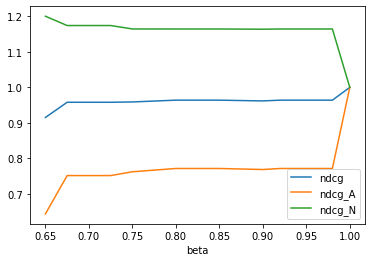

In [10]:
def plot_relative(df):
    denum = df.loc[df.beta == 1].iloc[0]
    df_ = df.div(denum, axis='columns')
    df_ = df_.sort_values('beta')
    df_ = df_.loc[df_.beta > 0.6]
    df_ = df_.set_index('beta')
#     print(df_) 
    df_.plot()

gdf = df.groupby(['dataset', 'suffix', 'feature_id'])
plot_relative(gdf.get_group(('yahoo', 'normal', 425))[['beta', 'ndcg', 'ndcg_A', 'ndcg_N']])

In [4]:

results_dir = '/ivi/ilps/personal/avardas/_data/groupbias/'
with open(results_dir + '5293191.out.pkl', 'rb') as f:
    results = pickle.load(f)
    
results = type('results', (object,), results)
print(results.group_config, results.dataset)
M = metrics.LTRMetrics(np.round(results.lv/4,0), np.diff(results.dlr), results.pred)
M.NDCG(10), M.ARR()

{'beta': 1.0, 'suffix': 'normal', 'feature_id': 99} yahoo


(0.6499215409655503, 0.7518162831423165)

In [5]:
M0 = metrics.LTRMetrics(np.round(results.lv/4,0)*(1 - results.g), np.diff(results.dlr), results.pred)
M1 = metrics.LTRMetrics(np.round(results.lv/4,0)*results.g, np.diff(results.dlr), results.pred)

print(M0.NDCG(10), M0.ARR())
print(M1.NDCG(10), M1.ARR())


0.5503334041477329 0.33338949530111134
0.5545791619068802 0.4184267878412052


---

# Fairness

In [27]:
jobids=['477680']
results = '/ivi/ilps/personal/avardas/_data/groupbias/'
files = os.listdir(results)
dfs = []
for file in files:
    if any([job in file for job in jobids]):
        with open(os.path.join(results, file), 'r') as f:
            dfs.append(pd.read_json(f, lines=True))
            
df = pd.concat(dfs)
extract_config(df, 'config')
extract_config(df, 'group_config')
df = df.set_index(['dataset', 'suffix', 'feature_id', 'utility_type', 'learn', 'beta']).sort_index()

In [29]:
df[['queries', 'ratio', 'ndcg', 'EEL', 'DTR']]

queries     ratio  \
dataset suffix feature_id utility_type learn beta                      
mslr    normal 126        estimated    False 0.60     5948  0.631663   
                                             0.60     5948  0.631663   
                                             0.75     5964  0.619250   
                                             0.75     5964  0.619250   
                                             0.90     5963  0.617843   
...                                                    ...       ...   
yahoo   normal 425        labels       True  0.60     6419  0.595455   
                                             0.75     6472  0.583703   
                                             0.75     6472  0.583703   
                                             0.90     6471  0.583184   
                                             0.90     6471  0.583184   

                                                       ndcg       EEL  \
dataset suffix feature_id utility_type learn beta                       
mslr    normal 126        estimated    False 0.60  0.609762       NaN   
                                             0.60  0.609762  0.145618   
                                             0.75  0.611727  0.144643   
                                             0.75  0.611727       NaN   
                                             0.90  0.611610       NaN   
...                                                     ...       ...   
yahoo   normal 425        labels       True  0.60  0.912322       NaN   
                                             0.75  0.948176       NaN   
                                             0.75  0.967661  0.109652   
                                             0.90  0.978019  0.038195   
                                             0.90  0.962625       NaN   

                                                        DTR  
dataset suffix feature_id utility_type learn beta            
mslr    normal 126        estimated    False 0.60  0.751559  
                                             0.60       NaN  
                                             0.75       NaN  
                                             0.75  0.729974  
                                             0.90  0.741936  
...                                                     ...  
yahoo   normal 425        labels       True  0.60  0.529918  
                                             0.75  0.359481  
                                             0.75       NaN  
                                             0.90       NaN  
                                             0.90  0.215369  

[112 rows x 5 columns]

In [31]:
df.index.unique(level='feature_id')

Int64Index([126, 130, 99, 425], dtype='int64', name='feature_id')

In [11]:
df

,jobid,config,queries,group_config,dataset,ratio,ndcg,EEL,DTR,config_vals
0,4776803,"{'metric': 'EEL', 'lr': 0.1, 'samples': 16, 's...",6471,"{'beta': 0.9, 'suffix': 'normal', 'feature_id'...",yahoo,0.583184,0.755909,0.190467,NaN,"[EEL, 0.1, 16, 4, 20, 50, 5, log, /ivi/ilps/pe..."
0,47768055,"{'metric': 'EEL', 'lr': 0.1, 'samples': 16, 's...",5948,"{'beta': 0.6000000000000001, 'suffix': 'normal...",mslr,0.631663,0.918171,0.127297,NaN,"[EEL, 0.1, 16, 4, 20, 50, 5, log, /ivi/ilps/pe..."
0,47768064,"{'metric': 'DTR', 'lr': 0.1, 'samples': 16, 's...",5344,"{'beta': 1, 'suffix': 'normal', 'feature_id': ...",mslr,0.565661,0.607533,NaN,0.712249,"[DTR, 0.1, 16, 4, 20, 50, 5, log, /ivi/ilps/pe..."
0,47768095,"{'metric': 'DTR', 'lr': 0.1, 'samples': 16, 's...",5964,"{'beta': 0.75, 'suffix': 'normal', 'feature_id...",mslr,0.619250,0.608051,NaN,0.747573,"[DTR, 0.1, 16, 4, 20, 50, 5, log, /ivi/ilps/pe..."
0,47768037,"{'metric': 'EEL', 'lr': 0.1, 'samples': 16, 's...",5963,"{'beta': 0.9, 'suffix': 'normal', 'feature_id'...",mslr,0.617843,0.607075,0.133017,NaN,"[EEL, 0.1, 16, 4, 20, 50, 5, log, /ivi/ilps/pe..."
...,...,...,...,...,...,...,...,...,...,...
0,477680102,"{'metric': 'DTR', 'lr': 0.1, 'samples': 16, 's...",6020,"{'beta': 0.75, 'suffix': 'normal', 'feature_id...",yahoo,0.648743,0.957426,NaN,0.358116,"[DTR, 0.1, 16, 4, 20, 50, 5, log, /ivi/ilps/pe..."
0,47768043,"{'metric': 'EEL', 'lr': 0.1, 'samples': 16, 's...",6328,"{'beta': 1, 'suffix': 'normal', 'feature_id': 99}",yahoo,0.587569,0.984681,0.024198,NaN,"[EEL, 0.1, 16, 4, 20, 50, 5, log, /ivi/ilps/pe..."
0,47768083,"{'metric': 'DTR', 'lr': 0.1, 'samples': 16, 's...",5948,"{'beta': 0.6000000000000001, 'suffix': 'normal...",mslr,0.631663,0.964603,NaN,0.747082,"[DTR, 0.1, 16, 4, 20, 50, 5, log, /ivi/ilps/pe..."
0,47768021,"{'metric': 'EEL', 'lr': 0.1, 'samples': 16, 's...",6419,"{'beta': 0.6000000000000001, 'suffix': 'normal...",yahoo,0.595455,0.967471,0.157634,NaN,"[EEL, 0.1, 16, 4, 20, 50, 5, log, /ivi/ilps/pe..."


---

### Learn Group

In [5]:
df = read_results(jobid='477862')
extract_config(df)

In [6]:
df

,jobid,dataset,train_docs,train_size,epoch,config,train,valid,loss,file_name,beta,suffix,feature_id
7,4778626,mslr,2270258,18918,20,"{'beta': 1, 'suffix': 'normal', 'feature_id': ...",0.997423,0.998723,28.352530,4778626.json,1,normal,130
7,4778627,mslr,2270258,18918,20,"{'beta': 1, 'suffix': 'normal', 'feature_id': ...",0.998256,0.999494,49.797184,4778627.json,1,normal,126
7,4778623,yahoo,473092,19943,20,"{'beta': 1, 'suffix': 'normal', 'feature_id': 99}",0.997029,0.998432,5.644953,4778623.json,1,normal,99
7,4778625,mslr,2270258,18918,20,"{'beta': 1, 'suffix': 'normal', 'feature_id': 13}",0.999301,0.999901,24.977591,4778625.json,1,normal,13
7,4778621,yahoo,473092,19943,20,"{'beta': 1, 'suffix': 'normal', 'feature_id': ...",0.996050,0.999411,6.676021,4778621.json,1,normal,263
7,4778624,yahoo,473092,19943,20,"{'beta': 1, 'suffix': 'normal', 'feature_id': ...",0.997093,0.999336,4.527394,4778624.json,1,normal,425
